# Customer Retention

In this notebook, I will be predicting customer churn for a Telco business using deep learning models.

Dataset: https://www.kaggle.com/blastchar/telco-customer-churn

View on Github: https://github.com/ehannell/customer_retention

## Import Libraries

In [211]:
#Data Modulation
import pandas as pd
import numpy as np

#Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#Machine Learning
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

## Load Data

The dataset is stored in the project's Github repository, which allow for easy data retrieval. The code is reproducable without having to download the dataset locally.

In [212]:
#url to the dataset
url = 'https://raw.githubusercontent.com/ehannell/customer_retention/main/Data/WA_Fn-UseC_-Telco-Customer-Churn.csv'

#create dataframe
df = pd.read_csv(url, error_bad_lines=False)

## Check & Manipulate the Data

In [213]:
#Summary of all the variables, along with missing values, data type, etc.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [214]:
#Build function to check unique values in our "object" variables
def variable_values(df):
    for column in df:
        if df[column].dtypes=='object':
            print(f'{column} : {df[column].unique()}')

In [215]:
#Check the values of each variable
variable_values(df)

customerID : ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
gender : ['Female' 'Male']
Partner : ['Yes' 'No']
Dependents : ['No' 'Yes']
PhoneService : ['No' 'Yes']
MultipleLines : ['No phone service' 'No' 'Yes']
InternetService : ['DSL' 'Fiber optic' 'No']
OnlineSecurity : ['No' 'Yes' 'No internet service']
OnlineBackup : ['Yes' 'No' 'No internet service']
DeviceProtection : ['No' 'Yes' 'No internet service']
TechSupport : ['No' 'Yes' 'No internet service']
StreamingTV : ['No' 'Yes' 'No internet service']
StreamingMovies : ['No' 'Yes' 'No internet service']
Contract : ['Month-to-month' 'One year' 'Two year']
PaperlessBilling : ['Yes' 'No']
PaymentMethod : ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
TotalCharges : ['29.85' '1889.5' '108.15' ... '346.45' '306.6' '6844.5']
Churn : ['No' 'Yes']


- Notice that TotalCharges actually contains numerical data. We learn that this column needs to be transformed numerical. 
- Note also that we have values like "No phone services", which seems to be similar to a simple "No". This should also be fixed

In [216]:
#Transform TotalCharges to numeric
df['TotalCharges'] = pd.to_numeric(df.TotalCharges, errors='coerce')

In [217]:
#Replace "No internet" with "No"
df.replace('No internet service', 'No', inplace=True)
df.replace('No phone service', 'No', inplace=True)

In [210]:
#check cleaned dataset
variable_values(df)

gender : ['Female' 'Male']
Partner : ['Yes' 'No']
Dependents : ['No' 'Yes']
PhoneService : ['No' 'Yes']
MultipleLines : ['No' 'Yes']
InternetService : ['DSL' 'Fiber optic' 'No']
OnlineSecurity : ['No' 'Yes']
OnlineBackup : ['Yes' 'No']
DeviceProtection : ['No' 'Yes']
TechSupport : ['No' 'Yes']
StreamingTV : ['No' 'Yes']
StreamingMovies : ['No' 'Yes']
Contract : ['Month-to-month' 'One year' 'Two year']
PaperlessBilling : ['Yes' 'No']
PaymentMethod : ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn : ['No' 'Yes']


In [196]:
#Drop CustomerID because it's unncessary for building our model
df.drop('customerID', axis='columns', inplace=True, errors='ignore')

In [197]:
#confirm that we don't have any missing values
df.isna().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [198]:
#Notice that we now have 11 rows of missing values for TotalCharges. We'll drop these because there are so few.
df = df.dropna()

In [199]:
#explore the first 5 rows of data
df.head(5)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [200]:
#explore the bottom 5 rows of data
df.tail(5)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
7038,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No
7039,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No
7040,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,Yes
7042,Male,0,No,No,66,Yes,No,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),105.65,6844.50,No


## Exploratory Data Analysis
This part of the project let's us explore the characteristics of all the dataset variables. Hence, we get an understanding for which variables could be relevant in building the actual model.

In [201]:
#Explore the statistical nature of our continuous variables
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,2283.300441
std,0.368844,24.545260,30.085974,2266.771362
min,0.000000,1.000000,18.250000,18.800000
25%,0.000000,9.000000,35.587500,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.862500,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


No     5163
Yes    1869
Name: Churn, dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


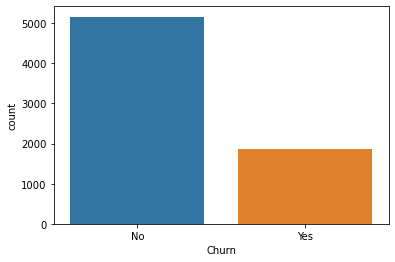

In [202]:
#Check the distribution of customers that churned and remained 
print(df['Churn'].value_counts())
print(sns.countplot(x='Churn', data=df))

In [203]:
#Closer look at the share of Yes vs. No
Remained = df[df.Churn == 'Yes'].shape[0]
Churned = df[df.Churn == 'No'].shape[0]

Total_customers = Remained + Churned
Remained_ratio = ( Remained / Total_customers) * 100
Churned_ratio = ( Churned / Total_customers) * 100
 
print("{:.2f}".format(Remained_ratio),'% of individuals remained as customer.')
print("{:.2f}".format(Churned_ratio),'% of individuals ended their relationship with the company.')
print('')
print('This means that we have a 73% chance of correctly guessing if that client left the company.')

26.58 % of individuals remained as customer.
73.42 % of individuals ended their relationship with the company.

This means that we have a 73% chance of correctly guessing if that client left the company.


<AxesSubplot:xlabel='InternetService', ylabel='count'>

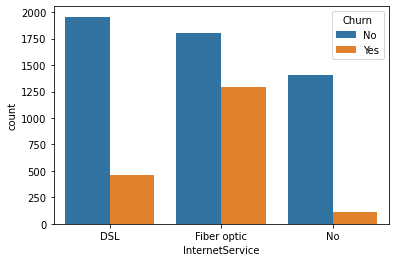

In [204]:
#Visualize distribution of churn count for certain classes
sns.countplot(x='InternetService', hue='Churn', data = df)

Tenure: Customers who have been with the company for long appear to remain a client
MonthlyCharges: In general, it seesm like clients who stayed pay a lower amount of monthly charges,
TotalCharges: However, it seems like TotalCharges follow a more similar pattern


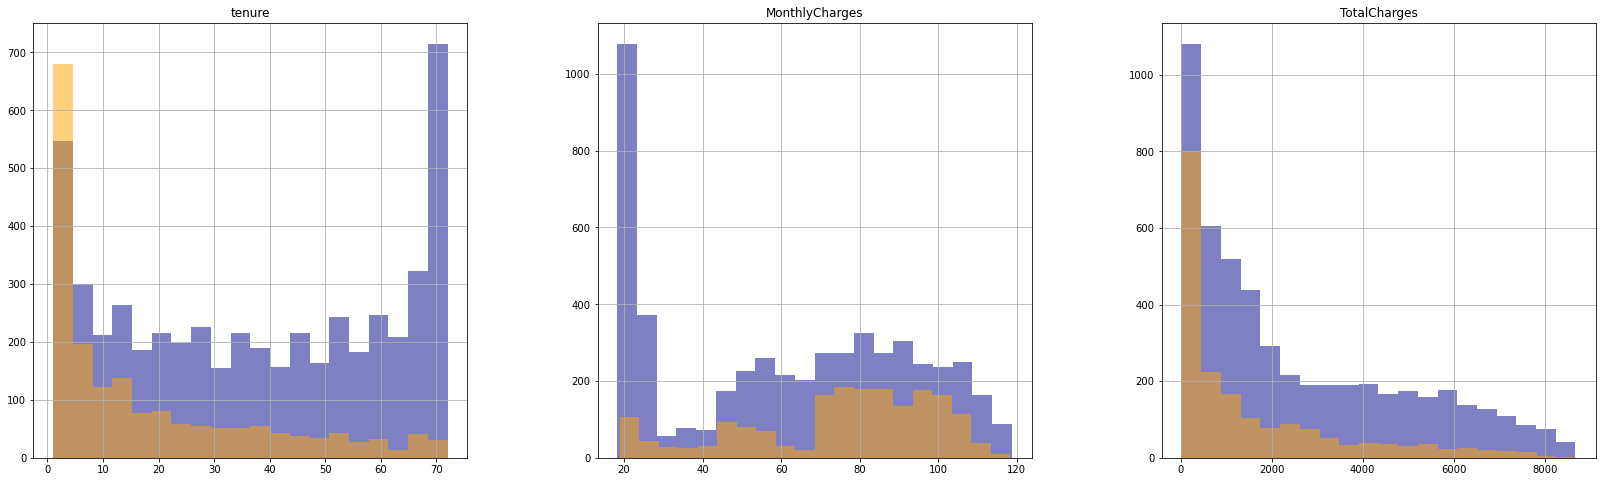

In [205]:
#Explore the numerical value distribution by churn variable
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
fig, ax = plt.subplots(1,3,figsize=(28,8))
df[df.Churn == 'No'][numerical_features].hist(bins=20, color='darkblue', alpha=0.5, ax = ax)
df[df.Churn == 'Yes'][numerical_features].hist(bins=20, color='orange', alpha=0.5, ax = ax)

print('Tenure: Customers who have been with the company for long appear to remain a client')
print('MonthlyCharges: In general, it seesm like clients who stayed pay a lower amount of monthly charges,')
print('TotalCharges: However, it seems like TotalCharges follow a more similar pattern')

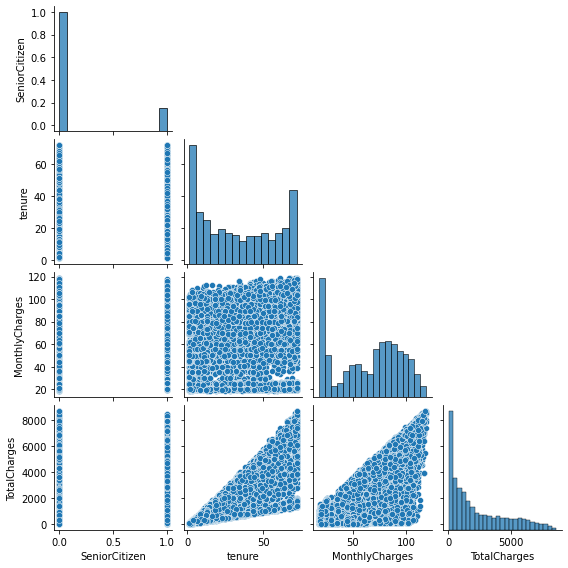

In [206]:
#Correlation Matrix
g = sns.pairplot(df, height=2)
for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].set_visible(False)

### Data Exploring Takeaways
1. We see that our classes are imbalanced, which means that we would be 